# Lib Imports

In [1]:
pip install numdifftools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/wganmodels/wgan_cse_lioc.pth
/kaggle/input/wganmodels/wgan_eth.pth
/kaggle/input/wganmodels/wgan_ltc.pth
/kaggle/input/wganmodels/wgan_btc.pth
/kaggle/input/wganmodels/wgan_cse_expo.pth
/kaggle/input/crypto-bottom-trained/BPC_BTC.model
/kaggle/input/crypto-bottom-trained/BPC_WGAN_ETH.model
/kaggle/input/crypto-bottom-trained/BPC_WGAN_LTC.model
/kaggle/input/preprocessed-data/LIOC_pca.csv
/kaggle/input/preprocessed-data/btc_pca.csv
/kaggle/input/preprocessed-data/eth_pca.csv
/kaggle/input/preprocessed-data/EXPO_pca.csv
/kaggle/input/preprocessed-data/ltc_pca.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad as torch_grad
import torch.nn.functional as F
from torch.autograd import Variable

import xgboost as xgb

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
from scipy.misc import derivative
import numdifftools as nd
from scipy.signal import argrelextrema
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import ADASYN

# Data Import

In [4]:
df=pd.read_csv("/kaggle/input/preprocessed-data/btc_pca.csv")
df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca11,pca13,pca14,pca16,pca17,pca18,pca19,pca20,pca21,Close
0,8.744221,-0.658155,-1.093340,1.176938,-0.600751,0.026237,-0.359053,0.953242,-0.384168,-0.651644,1.318398,-1.074751,-0.619783,0.330380,0.079497,-0.023768,-0.397569,13761.50
1,8.735730,-1.444550,-0.894045,1.317192,-0.625199,0.668508,0.187651,0.723749,0.073215,-2.282633,0.713949,-1.182119,-0.148796,0.673623,0.072780,-0.063445,-0.497342,13792.66
2,8.766185,-1.117762,-0.750429,0.095987,-0.725724,0.366221,0.253420,0.077264,1.710729,0.324876,-0.788650,-1.095183,-0.214677,0.895774,0.097829,-0.167460,-0.486162,13792.35
3,8.713572,-1.480208,-1.114621,0.445480,-0.911416,2.514267,0.581901,-0.143601,0.889499,-0.816233,-0.254987,-1.091789,-0.075686,0.902458,0.077003,-0.013148,-0.541326,13799.99
4,8.754863,-1.396565,-0.814961,0.131886,-0.800946,3.031047,0.010632,1.081172,-0.577558,-0.129734,0.952726,-1.102891,-0.133230,0.951209,0.096098,-0.127653,-0.519283,13800.65


In [5]:
print(df.shape)

(209107, 18)


In [6]:
def NaNCheck(data):
  return data.isnull().sum()[data.isnull().sum()>0]

print(NaNCheck(df))

Series([], dtype: int64)


# Data Preprocess 

### Sliding Window Function

In [7]:
def sliding_window(x, y, y_raw ,feature_window,label_window,trend_window):
    x_ = []
    y_ = []
    y_gan_pr = []
    y_gan_cl = []
    y_gan_tr = []
    backward_length = max(trend_window,label_window)
    for i in range(backward_length, x.shape[0]-label_window):
        tmp_x = x[i - feature_window: i, :]
        tmp_y = y[i]
        tmp_y_gan_pr = y[i - feature_window: i + 1]
        tmp_y_gan_cl = y_raw[i - label_window: i + label_window+1]
        tmp_y_gan_tr = y_raw[i - trend_window: i, :]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan_pr.append(tmp_y_gan_pr)
        y_gan_cl.append(tmp_y_gan_cl)
        y_gan_tr.append(tmp_y_gan_tr)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan_pr = torch.from_numpy(np.array(y_gan_pr)).float()
    y_gan_cl = torch.from_numpy(np.array(y_gan_cl)).float()
    y_gan_tr = torch.from_numpy(np.array(y_gan_tr)).float()
    return x_, y_, y_gan_pr,y_gan_cl,y_gan_tr


### Trend Ditection Component

In [8]:
def trend_detection(data):
    n = data.shape[1]
    sets = data.shape[0]
    mean_derivatives = np.zeros((sets,1))
    
    data = data.numpy()

    for i in range(sets):
        # Select the i-th 20 set
        x = np.arange(1,n+1)
        x_fake = np.arange(1.1, n, 0.1)
        y = data[i, :, 0]
        # Simple interpolation of x and y    
        f = interp1d(x, y)
        
        # derivative of y with respect to x
        df_dx = nd.Derivative(f, step=1e-6)(x_fake)
        # Calculate the mean derivative for the i-th 20 set
        average = np.average(df_dx)
        mean_derivatives[i][0] = average
    return  torch.from_numpy(mean_derivatives)   

### Constants

In [45]:
training_duration = 4032
validation_duration = 864
testing_duration = 8640
train_offset = 8640*4+4032
smoothing_threshold = 50
sliding_window_size = 10
classification_label_size = 12
trend_measure_lenth = 12

### Train test split

In [46]:
labels_df = df["Close"]
features_df = df.drop(columns=["Close"])

st_train = train_offset
train_x = features_df.iloc[st_train:st_train+training_duration]
train_y = labels_df.iloc[st_train:st_train+training_duration]

# st_test = training_duration+validation_duration+st_train
st_test = 864
test_x = features_df.iloc[st_test:st_test+testing_duration]
test_y = labels_df.iloc[st_test:st_test+testing_duration]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')


trainX: (4032, 17) trainY: (4032,)
testX: (8640, 17) testY: (8640,)


### Scalling

In [47]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))
trend_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

raw_train_y = train_y.values.reshape(-1, 1)
raw_test_y = test_y.values.reshape(-1, 1)
train_y = y_scaler.fit_transform(train_y.values.reshape(-1, 1))
test_y = y_scaler.transform(test_y.values.reshape(-1, 1))

### Dataset preparation for models

In [48]:
# For price prediction model
train_x_slide, train_y_slide, train_y_gan,train_y_gan_cl,train_direction_slide = sliding_window(train_x, train_y,raw_train_y, sliding_window_size,classification_label_size,trend_measure_lenth)                
test_x_slide, test_y_slide, test_y_gan,test_y_gan_cl,test_direction_slide = sliding_window(test_x, test_y, raw_test_y ,sliding_window_size,classification_label_size,trend_measure_lenth)

train_trend_features = trend_detection(train_direction_slide)
test_trend_features = trend_detection(test_direction_slide)
train_trend_features = torch.tensor(trend_scaler.fit_transform(train_trend_features))
test_trend_features = torch.tensor(trend_scaler.transform(test_trend_features))
new_feature_tensor_train = train_trend_features.repeat(1,10)
new_feature_tensor_train = new_feature_tensor_train.unsqueeze(2)
new_feature_tensor_test = test_trend_features.repeat(1,10)
new_feature_tensor_test = new_feature_tensor_test.unsqueeze(2)

print('For Price prediction')
print(f'train_x_slide: {train_x_slide.shape} train_y_slide: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x_slide: {test_x_slide.shape} test_y_slide: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}\n')

print('For Bottom classification')
print(f'train_x_slide: {train_x_slide.shape} train_y_gan_cl: {train_y_gan_cl.shape}')
print(f'test_x_slide: {test_x_slide.shape} test_y_gan_cl: {test_y_gan_cl.shape}\n')

print('For current trend calculation')
print(f'train_direction_slide: {train_direction_slide.shape} train_trend_features: {train_trend_features.shape} ')
print(f'test_direction_slide: {test_direction_slide.shape} test_trend_features: {test_trend_features.shape} ')

For Price prediction
train_x_slide: torch.Size([4008, 10, 17]) train_y_slide: torch.Size([4008, 1]) train_y_gan: torch.Size([4008, 11, 1])
test_x_slide: torch.Size([8616, 10, 17]) test_y_slide: torch.Size([8616, 1]) test_y_gan: torch.Size([8616, 11, 1])

For Bottom classification
train_x_slide: torch.Size([4008, 10, 17]) train_y_gan_cl: torch.Size([4008, 25, 1])
test_x_slide: torch.Size([8616, 10, 17]) test_y_gan_cl: torch.Size([8616, 25, 1])

For current trend calculation
train_direction_slide: torch.Size([4008, 12, 1]) train_trend_features: torch.Size([4008, 1]) 
test_direction_slide: torch.Size([8616, 12, 1]) test_trend_features: torch.Size([8616, 1]) 


# Model Implementation

## GAN Model

#### Generator

In [15]:
class Generator(nn.Module):
    
    def __init__(self, input_size):
        super().__init__()

        # 3 GRU layers, input_size = features
        self.gru_1 = nn.GRU(input_size, 1024, batch_first=True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        # 3 Dense Layers
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(0.2)
        self.tanh = nn.Tanh()


    def forward(self, x,use_cuda=1):
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device) # initial hidden state for the 1st GRU Layer - (num of layers in the GRU, batch size, num of hidden units in the GRU)
        out_gru_1, _ = self.gru_1(x, h0)
        out_gru_1 = self.dropout(out_gru_1)

        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_gru_2, _ = self.gru_2(out_gru_1, h1)
        out_gru_2 = self.dropout(out_gru_2)

        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_gru_3, _ = self.gru_3(out_gru_2, h2)
        out_gru_3 = self.dropout(out_gru_3)

        out_dense_1 = self.linear_1(out_gru_3[:, -1, :])
        out_dense_2 = self.linear_2(out_dense_1)
        out_dense_3 = self.linear_3(out_dense_2)

        return out_dense_3,out_gru_3

#### Discriminator

In [16]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    # 3 1D Conv layers
    self.conv1 = nn.Conv1d(sliding_window_size+1, 32, kernel_size = 5, stride = 1, padding = 'same')
    self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
    self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')

    # 3 linear layers
    self.linear1 = nn.Linear(128, 220)
    self.linear2 = nn.Linear(220, 220)
    self.linear3 = nn.Linear(220, 1)

    self.leaky = nn.LeakyReLU(0.01)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    conv1 = self.conv1(x)
    conv1 = self.leaky(conv1)
    conv2 = self.conv2(conv1)
    conv2 = self.leaky(conv2)
    conv3 = self.conv3(conv2)
    conv3 = self.leaky(conv3)

    flatten_x =  conv3.reshape(conv3.shape[0], conv3.shape[1])

    out_1 = self.linear1(flatten_x)
    out_1 = self.leaky(out_1)
    out_2 = self.linear2(out_1)
    out_2 = self.relu(out_2)
    out_3 = self.linear3(out_2)

    return out_3

#### Gradient Panelty

In [17]:
def grad_penalty_fnc(real_data, gen_data,D,cuda,gp_weight):
    batch_size = real_data.size()[0]
    t = torch.rand((batch_size, 1, 1), requires_grad=True)
    t = t.expand_as(real_data)

    if cuda:
        t = t.cuda()

    # mixed sample from real and fake; make approx of the 'true' gradient norm
    interpol = t * real_data.data + (1-t) * gen_data.data

    if cuda:
        interpol = interpol.cuda()
    prob_interpol = D(interpol)
    torch.autograd.set_detect_anomaly(True)
    gradients = torch_grad(outputs=prob_interpol, inputs=interpol,
                           grad_outputs=torch.ones(prob_interpol.size()).cuda() if cuda else torch.ones(
                               prob_interpol.size()), create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(batch_size, -1)
    #grad_norm = torch.norm(gradients, dim=1).mean()
    #self.losses['gradient_norm'].append(grad_norm.item())

    # add epsilon for stability
    eps = 1e-10
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1, dtype=torch.double) + eps)
    #gradients = gradients.cpu()
    # comment: precision is lower than grad_norm (think that is double) and gradients_norm is float
    final = gp_weight * (torch.max(torch.zeros(1,dtype=torch.double).cuda() if cuda else torch.zeros(1,dtype=torch.double), gradients_norm.mean() - 1) ** 2), gradients_norm.mean().item()
    return final


## Bottom Point Classification Model

### Bottom Point Labeling

In [18]:
def find_bottom_point_labels_mean(y,slide):

    y1 = y[:, :slide, :] # 128,10,1
    y2 = y[:, slide+1:, :]
    values = y[:,slide,:]

    y_avg = torch.mean(y1,dim=1)
    y_next_avg = torch.mean(y2, dim=1)
    y_bool = y_avg>(y[:,slide,:] + smoothing_threshold) 
    y_next_bool = y_next_avg>(y[:,slide,:] + smoothing_threshold)
    result = np.logical_and(y_bool.numpy(), y_next_bool.numpy())
    y_label=np.where(result, 1, 0)
    
    index_val = np.where(y_label == 1)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure(figsize=(15, 8))
    plt.plot(y[:,slide,:], zorder=0)
    plt.scatter(index_val[0], values[np.where(y_label == 1)],
      label='Minima', s=100, color=colors[1], marker='^')
    plt.legend()
    plt.show()

    y_labels = torch.from_numpy(y_label)

    return y_labels

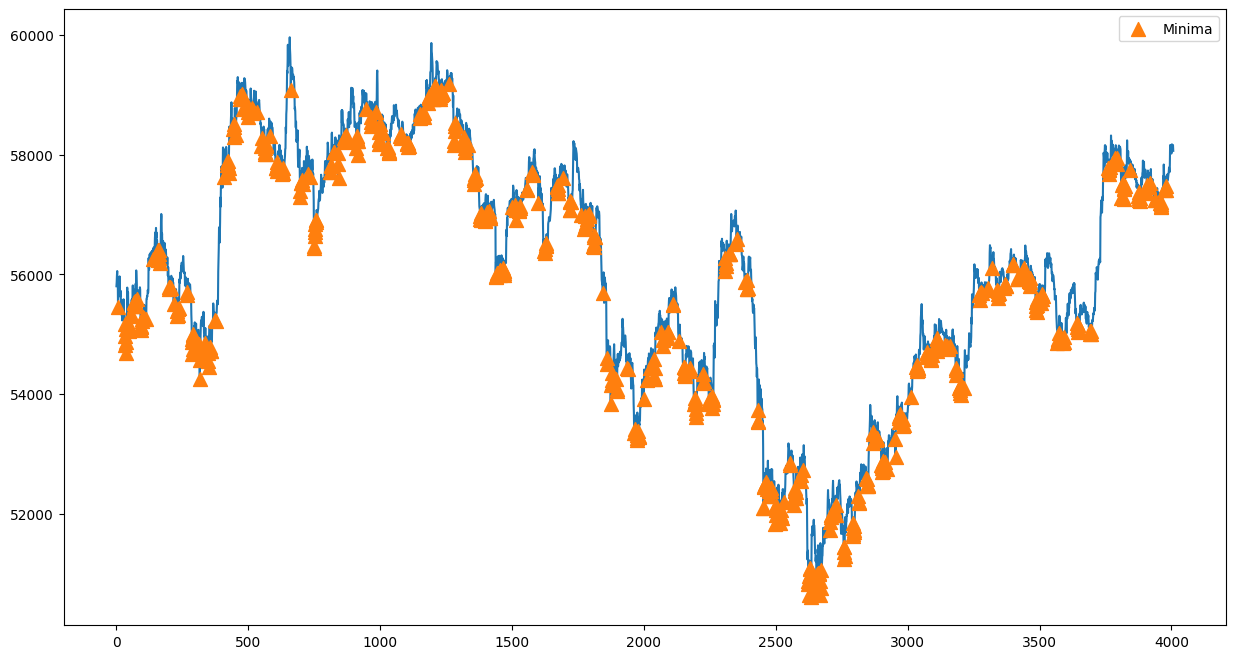

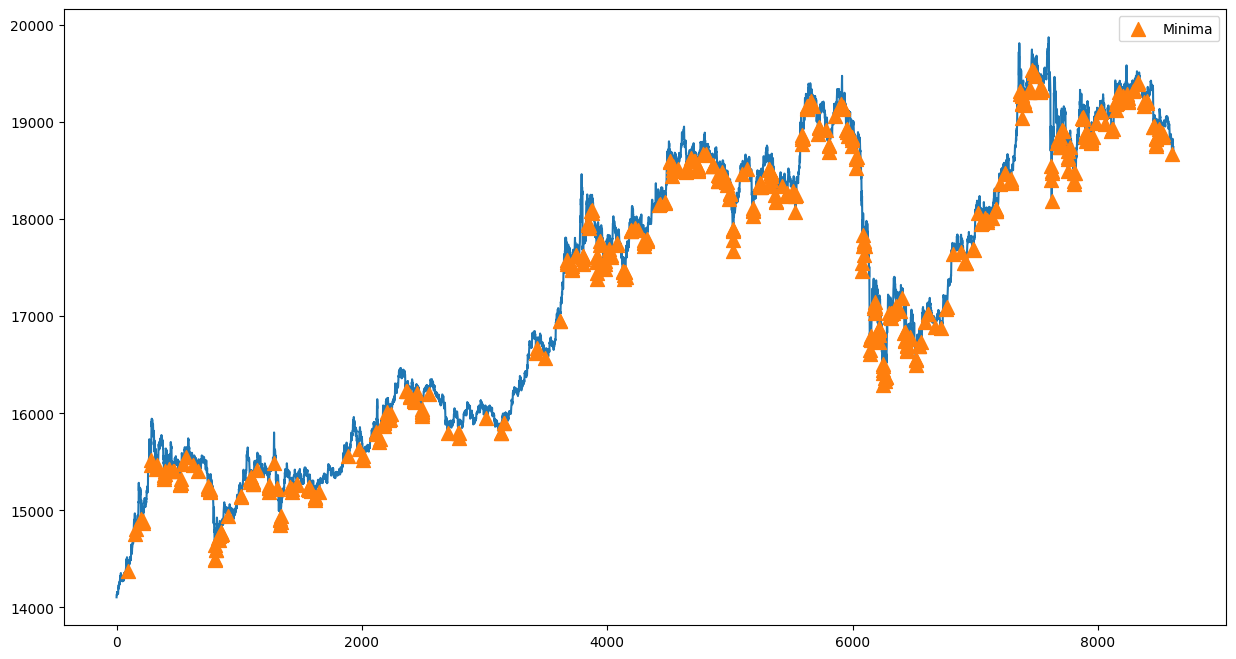

[3342  666]
[8107  509]
5.018018018018018


In [49]:
def calc_labels(labels):
    unique_labels = torch.unique(labels)
    unique_labels, label_counts = np.unique(labels.numpy(), return_counts=True)
    return label_counts 

train_bottoms = find_bottom_point_labels_mean(train_y_gan_cl,classification_label_size)
test_bottoms = find_bottom_point_labels_mean(test_y_gan_cl,classification_label_size)
train_bottom_count = calc_labels(train_bottoms)
test_bottom_count = calc_labels(test_bottoms)
print(train_bottom_count)
print(test_bottom_count)
print(train_bottom_count[0]/train_bottom_count[1])

### Bottom Point Implementation - XGBoost

In [20]:
spw = train_bottom_count[0]/train_bottom_count[1]
device = 'cpu'

def xgboost_train(x,y,eta=0.1):
    x = x.reshape(x.shape[0], -1)
    adasyn = ADASYN(sampling_strategy=0.3, random_state=42)
    x, y = adasyn.fit_resample(x.detach().cpu().numpy(), y.detach().cpu().numpy())
    model= xgb.XGBClassifier(
        n_estimators=700, 
        max_depth=7, 
        learning_rate=0.1,
        objective='binary:logistic',
        eval_metric='aucpr',
        subsample = 0.1,
        colsample_bytree = 0.15,
        min_child_weight= 15,
        reg_alpha=0.7,
    )
    model.fit(x,y)
    return model
        
def xgboost_test(x, y,xgmodel):
    out_gru_3_xg = x.reshape(x.shape[0], -1)
    pred = xgmodel.predict(out_gru_3_xg.detach().cpu().numpy())
    pred = torch.tensor(pred).reshape(pred.shape[0],1)
    return pred,y

### Test with pretrained GAN model

In [39]:
# learning_rate_xgboost2 = 0.3

modelG2 = Generator(train_x.shape[1]) #.to(device)
modelG2.load_state_dict(torch.load("/kaggle/input/wganmodels/wgan_btc.pth",map_location=torch.device('cpu')))
modelG2.eval()

_,train_input_features = modelG2(train_x_slide.to(device))
train_input_features = torch.cat((train_input_features, new_feature_tensor_train), dim=2)
xgb_model = xgboost_train(train_input_features,train_bottoms)

pred_direction_train,true_direction_train = xgboost_test(train_input_features,train_bottoms,xgb_model)
pred_direction_train = torch.round(pred_direction_train).long()
f1_score_val_train =  f1_score(train_bottoms.numpy(), pred_direction_train.numpy())
precision_score_val_train = precision_score(train_bottoms.numpy(), pred_direction_train.numpy(),zero_division=0)
recall_score_train = recall_score(train_bottoms.numpy(), pred_direction_train.numpy(), average='micro')

_,test_input_features = modelG2(test_x_slide.to(device))
test_input_features = torch.cat((test_input_features, new_feature_tensor_test), dim=2)
pred_direction_test,true_direction_test = xgboost_test(test_input_features,test_bottoms,xgb_model)                  
pred_direction_test = torch.round(pred_direction_test).long()
f1_score_val_test = f1_score(test_bottoms.numpy(), pred_direction_test.numpy())
precision_score_val_test = precision_score(test_bottoms.numpy(), pred_direction_test.numpy(),zero_division=0)
recall_score_test = recall_score(test_bottoms.numpy(), pred_direction_test.numpy(), average='micro')

print("F1_score_train:", f1_score_val_train)
print("Precision_train: ",precision_score_val_train)
print("Recall_train: ",recall_score_train)
print("F1_score_test:", f1_score_val_test)
print("Precision_test: ",precision_score_val_test)
print("Recall_test: ",recall_score_test)

F1_score_train: 0.45833333333333337
Precision_train:  0.6205128205128205
Recall_train:  0.8572854291417166
F1_score_test: 0.07692307692307693
Precision_test:  0.4375
Recall_test:  0.9580838323353293


In [ ]:
xgb_model.save_model("BPC_BTC.model")

# Buy  Hold Strategy

### Get predictions

In [50]:
modelG = Generator(train_x.shape[1]) #.to(device)
modelG.load_state_dict(torch.load("/kaggle/input/wganmodels/wgan_btc.pth",map_location=torch.device('cpu')))
modelG.eval()
model_xgboost1 = xgb.XGBClassifier()
model_xgboost1.load_model("/kaggle/input/crypto-bottom-trained/BPC_BTC.model")

_,test_input_features = modelG(test_x_slide.to(device))
test_input_features = torch.cat((test_input_features, new_feature_tensor_test), dim=2)
pred_direction_test,true_direction_test = xgboost_test(test_input_features,test_bottoms,model_xgboost1)                  
pred_direction_test = torch.round(pred_direction_test).long()
f1_score_val_test = f1_score(test_bottoms.numpy(), pred_direction_test.numpy())
precision_score_val_test = precision_score(test_bottoms.numpy(), pred_direction_test.numpy(),zero_division=0)
recall_score_test = recall_score(test_bottoms.numpy(), pred_direction_test.numpy(), average='micro')


print("F1_score_test:", f1_score_val_test)
print("Precision_test: ",precision_score_val_test)
print("Recall_test: ",recall_score_test)

F1_score_test: 0.08214285714285714
Precision_test:  0.45098039215686275
Recall_test:  0.9403435468895079


In [51]:
predicted_bottom_count = calc_labels(pred_direction_test)
Actual_bottom_count = calc_labels(test_bottoms)
print("Predicted bottoms",predicted_bottom_count)
print("Actual bottoms",Actual_bottom_count)

Predicted bottoms [8565   51]
Predicted bottoms [8107  509]


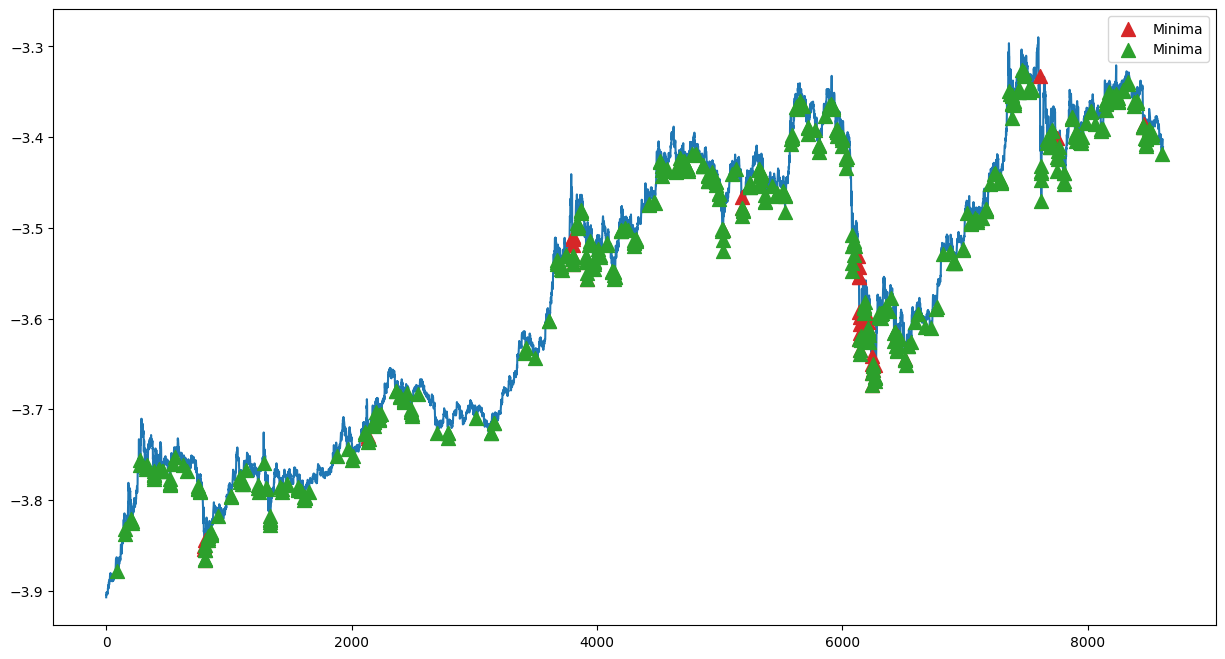

In [52]:
y_label=pred_direction_test
y_label_true = test_bottoms

index_val = np.where(y_label == 1)
index_val_true = np.where(y_label_true == 1)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(15, 8))
plt.plot(test_y_slide, zorder=0)
plt.scatter(index_val[0], test_y_slide[np.where(y_label == 1)],
  label='Minima', s=100, color=colors[3], marker='^')
plt.scatter(index_val_true[0], test_y_slide[np.where(y_label_true == 1)],
  label='Minima', s=100, color=colors[2], marker='^')
plt.legend()
plt.show()

In [53]:
predictions = torch.squeeze(pred_direction_test)
indices = torch.nonzero(predictions).flatten()
print(indices)

tensor([ 389,  800,  801,  802,  806, 2137, 2138, 3802, 3803, 3805, 3806, 3807,
        3808, 3809, 3917, 3918, 5028, 5186, 5187, 6132, 6134, 6135, 6136, 6138,
        6140, 6141, 6143, 6147, 6148, 6206, 6209, 6210, 6211, 6213, 6214, 6242,
        6244, 6245, 6246, 6247, 6248, 6249, 6271, 6427, 6445, 6447, 6514, 7609,
        7747, 8453, 8460])


In [54]:
close_values = torch.squeeze(test_y_gan_cl[:,classification_label_size,:])

In [56]:
gained_prof = []
actual_prof = []

for i in indices:
    entry_point = close_values[i]
    exit_points = close_values[i+1:i+classification_label_size]
    exit_value, exit_index = torch.max(exit_points, dim=0)
    profit_gained = exit_value - entry_point

    intermediate_points = close_values[i:i+1+exit_index]
    best_point,best_point_index = torch.min(intermediate_points,dim=0)
    profit_actual = exit_value - best_point
    
    gained_prof.append(profit_gained)
    actual_prof.append(profit_actual)
    

In [57]:
gained_avg = sum(gained_prof)/len(indices)
actual_avg = sum(actual_prof)/len(indices)
print(gained_avg)
print(actual_avg)

tensor(185.7012)
tensor(264.2576)
